In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy.random import default_rng
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import healpy as hp
from healpy.newvisufunc import projview

### Functions

In [3]:
def compute_dipole(map_, mask=None):
    # fit monopole and dipole:
    map_ = [float(pix) for pix in map_]  # need to convert all entries to floats to avoid error in remove_dipole()
    map_nodip = np.array(map_)
    if mask is not None:
        map_nodip[mask==0.] = hp.UNSEEN
    map_nodip, monopole, dipole = hp.pixelfunc.remove_dipole(map_nodip, fitval=True)
    # direction
    lon, lat = hp.rotator.vec2dir(dipole, lonlat=True)
    # amplitude
    dipamp = np.linalg.norm(dipole)

    print(f"monopole: {monopole:.6f}")
    print(f"dipole: {dipole}")
    print(f"  dir ({lon:.3f}, {lat:.3f}), amplitude {dipamp:.6f}")
    
    # create SkyCoord object
    dipole = SkyCoord(lon, lat, unit=u.deg, frame='galactic')
    
    return dipamp, dipole

In [4]:
def get_galmask(l, b, blim, NSIDE=128):
    # get galactic mask
    galmask = np.abs(b)>blim
    lmask, bmask = l[galmask], b[galmask]  # only returns (l,b) where |b|<(blim)deg
    # format into healpy map
    NPIX = hp.nside2npix(NSIDE)
    pix_idx = hp.ang2pix(NSIDE, lmask, bmask, lonlat=True)
    galmask = np.bincount(pix_idx, minlength=NPIX)
    return galmask

### Healpy params

In [5]:
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)

### Load catalog

In [6]:
# clean G<20.0
quasar_fn = '/scratch/aew492/quasars/catalogs/catalog_G20.0.fits'
data_quaia = Table.read(quasar_fn, format='fits')
# number of sources + galactic coordinates
nd = len(data_quaia)
l, b = data_quaia['l'], data_quaia['b']

In [7]:
# format into healpy map
pix_idx = hp.ang2pix(NSIDE, l, b, lonlat=True)
map_data = np.bincount(pix_idx, minlength=NPIX)

#### Compute dipole: no cuts

In [8]:
dipamp_nocuts, dipdir_nocuts = compute_dipole(map_data)

monopole: 3.844452
dipole: [-0.15280942 -0.18966379  0.21782923]
  dir (-128.858, 41.808), amplitude 0.326761


### Galactic cuts: $\vert b\vert < 30^\circ$ and $\vert b\vert < 60^\circ$

#### $\vert b\vert < 30^\circ$

In [9]:
# mask around the galactic plane
blim = 30
galmask = get_galmask(l, b, blim)

In [10]:
# distribution of b coords
# fig, axs = plt.subplots(1, 2, figsize=(12,3))

# _, _, _ = axs[0].hist(lmask, bins=120, alpha=0.5)
# axs[0].set_xlabel('l')
# axs[0].set_ylabel('sources')

# _, _, _ = axs[1].hist(bmask, bins=120, alpha=0.5)
# axs[1].axvline(-blim, color='k', alpha=0.5, lw=0.5)
# axs[1].axvline(blim, color='k', alpha=0.5, lw=0.5)
# axs[1].set_xlabel('b')

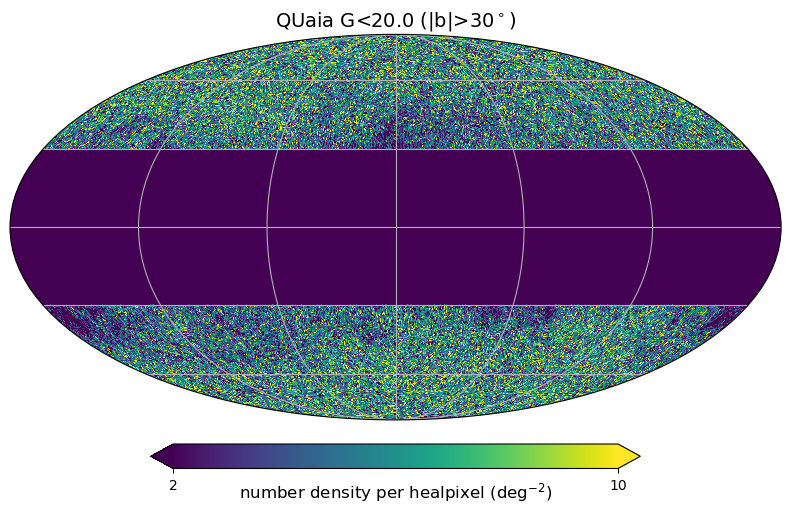

In [11]:
projview(galmask, title=f'QUaia G<20.0 (|b|>{blim}$^\circ$)', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
        min=2, max=10)

In [12]:
# compute dipole
dipamp_b30, dipdir_b30 = compute_dipole(map_data, mask=galmask)

monopole: 5.438313
dipole: [-0.07974989 -0.11179974  0.13959643]
  dir (-125.501, 45.469), amplitude 0.195822


#### $\vert b\vert < 45^\circ$

In [13]:
galmask = get_galmask(l, b, blim=45)
dipamp_b45, dipdir_b45 = compute_dipole(map_data, mask=galmask)

monopole: 5.736870
dipole: [-0.07019189 -0.14750884  0.08707207]
  dir (-115.447, 28.058), amplitude 0.185114


#### $\vert b\vert < 60^\circ$

In [14]:
galmask = get_galmask(l, b, blim=60)
dipamp_b60, dipdir_b60 = compute_dipole(map_data, mask=galmask)

monopole: 5.896778
dipole: [-0.03293555 -0.09424353  0.03093455]
  dir (-109.263, 17.216), amplitude 0.104516


### Compare dipoles computed with and without galactic cuts

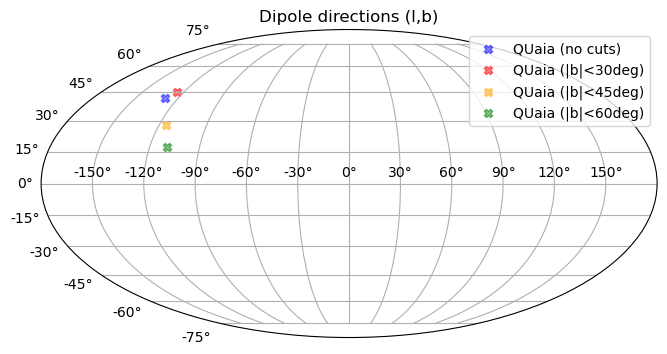

In [15]:
plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection='mollweide')
plt.grid(True)

m = 'X'
plt.scatter(dipdir_nocuts.l.wrap_at(np.pi*u.radian).to('radian'), dipdir_nocuts.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='b', alpha=0.5, label='QUaia (no cuts)')
plt.scatter(dipdir_b30.l.wrap_at(np.pi*u.radian).to('radian'), dipdir_b30.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='r', alpha=0.5, label='QUaia (|b|<30deg)')
plt.scatter(dipdir_b45.l.wrap_at(np.pi*u.radian).to('radian'), dipdir_b45.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='orange', alpha=0.5, label='QUaia (|b|<45deg)')
plt.scatter(dipdir_b60.l.wrap_at(np.pi*u.radian).to('radian'), dipdir_b60.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='g', alpha=0.5, label='QUaia (|b|<60deg)')

plt.title('Dipole directions (l,b)')
ax.legend()

In [16]:
dipamp_nocuts, dipamp_b60

(0.3267608404965523, 0.10451573625594998)